In [10]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,8)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

# Dataset

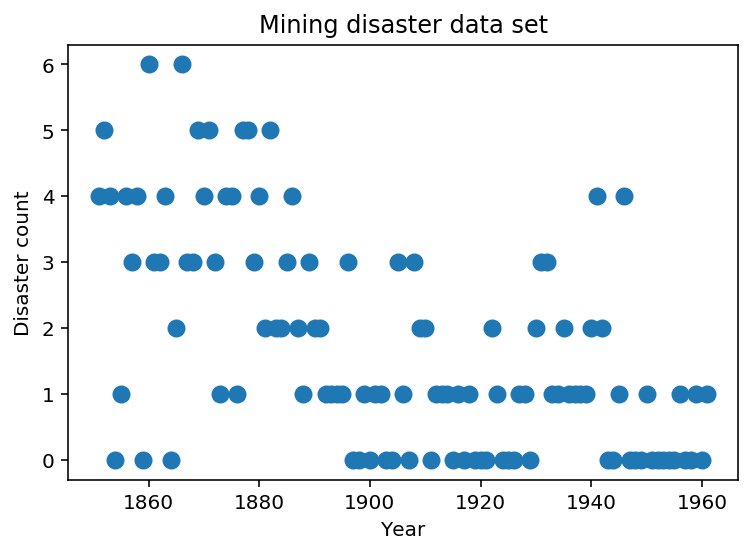

In [11]:
disaster_data = np.array([ 4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                           3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                           2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                           1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                           0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                           3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                           0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])
years = np.arange(1851, 1962)
plt.plot(years, disaster_data, 'o', markersize=8);
plt.ylabel('Disaster count')
plt.xlabel('Year')
plt.title('Mining disaster data set')
plt.show()

In [3]:
def disaster_count_model(disaster_rate_fn):
  disaster_count = tfd.JointDistributionNamed(dict(
    e=tfd.Exponential(rate=1.),
    l=tfd.Exponential(rate=1.),
    s=tfd.Uniform(0., high=len(years)),
    d_t=lambda s, l, e: tfd.Independent(
        tfd.Poisson(rate=disaster_rate_fn(np.arange(len(years)), s, l, e)),
        reinterpreted_batch_ndims=1)
  ))
  return disaster_count

def disaster_rate_switch(ys, s, l, e):
  return tf.where(ys < s, e, l) # returns array [e, e, e,.. l, l,..]. Not differentiable

def disaster_rate_sigmoid(ys, s, l, e):
  return e + tf.sigmoid(ys - s) * (l - e)

model_switch = disaster_count_model(disaster_rate_switch)
model_sigmoid = disaster_count_model(disaster_rate_sigmoid)

Quick check of the models

In [8]:
def target_log_prob_fn(model, s, e, l):
  return model.log_prob(s=s, e=e, l=l, d_t=disaster_data)

models = [model_switch, model_sigmoid]
print([target_log_prob_fn(m, 40., 3., .9).numpy() for m in models])  # Somewhat likely result
print([target_log_prob_fn(m, 60., 1., 5.).numpy() for m in models])  # Rather unlikely result
print([target_log_prob_fn(m, -10., 1., 1.).numpy() for m in models]) # Impossible result

[-176.94559, -176.28717]
[-371.3125, -366.8816]
[-inf, -inf]


In [5]:
num_results = 10000
num_burnin_steps = 3000

@tf.function(autograph=False)
def make_chain(target_log_prob_fn):
   kernel = tfp.mcmc.TransformedTransitionKernel(
       inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
          target_log_prob_fn=target_log_prob_fn,
          step_size=0.05,
          num_leapfrog_steps=3),
       # The order is according to target_log_prob_fn arguments order
       bijector=[ 
          # The switchpoint is constrained between zero and len(years).
          # Hence we supply a bijector that maps the real numbers (in a
          # differentiable way) to the interval (0;len(yers))
          # y - (0;len(yers)), x - (-inf;+inf)
          tfb.Sigmoid(low=0., high=tf.cast(len(years), dtype=tf.float32)),
          # Early and late disaster rate: The exponential distribution is
          # defined on the positive real numbers
          # y - (0;+inf), x - (-inf;+inf)
          tfb.Softplus(),
          # y - (0;+inf), x - (-inf;+inf)
          tfb.Softplus(),
      ])
   kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=kernel,
        num_adaptation_steps=int(0.8*num_burnin_steps))

   states = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=[
          # The three latent variables
          tf.ones([], name='init_switchpoint'),
          tf.ones([], name='init_early_disaster_rate'),
          tf.ones([], name='init_late_disaster_rate'),
      ],
      trace_fn=None,
      kernel=kernel)
   return states

In [6]:
switch_samples = [s.numpy() for s in make_chain(
    lambda *args: target_log_prob_fn(model_switch, *args))]
sigmoid_samples = [s.numpy() for s in make_chain(
    lambda *args: target_log_prob_fn(model_sigmoid, *args))]

switchpoint, early_disaster_rate, late_disaster_rate = zip(
    switch_samples, sigmoid_samples)

In [13]:
switchpoint

(array([42.6568 , 42.6568 , 38.90861, ..., 36.56224, 35.9322 , 39.15234],
       dtype=float32),
 array([39.17569 , 39.17569 , 40.49144 , ..., 38.214302, 39.28644 ,
        39.542805], dtype=float32))

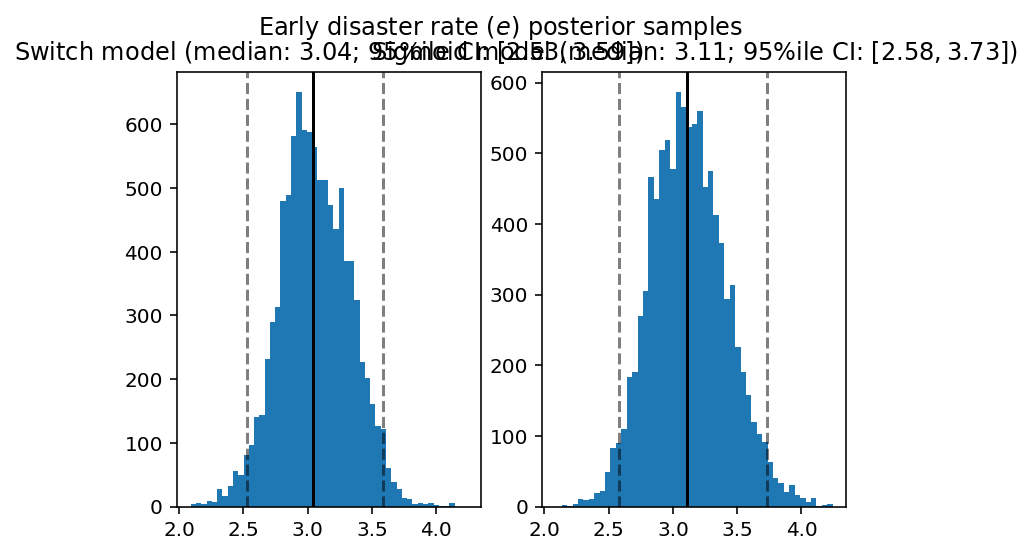

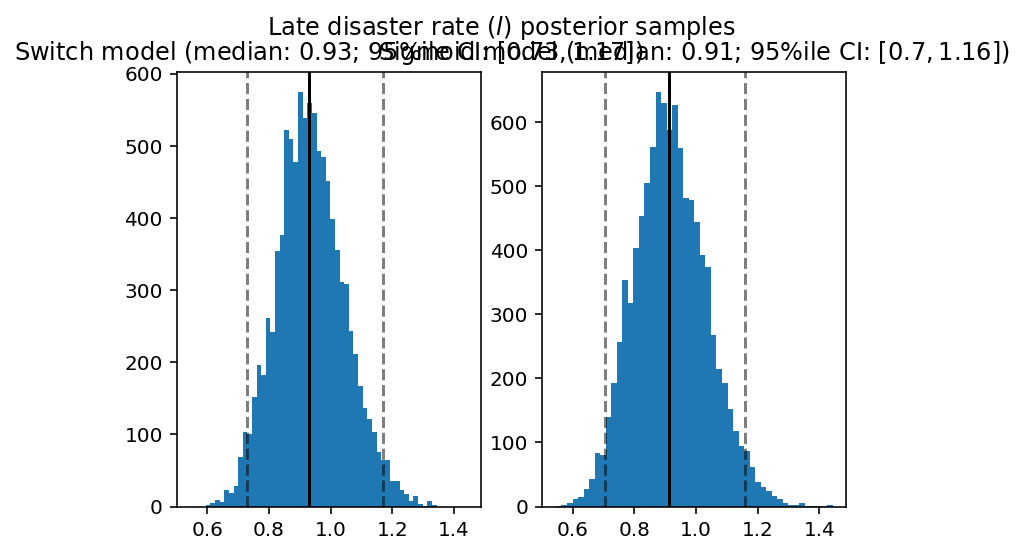

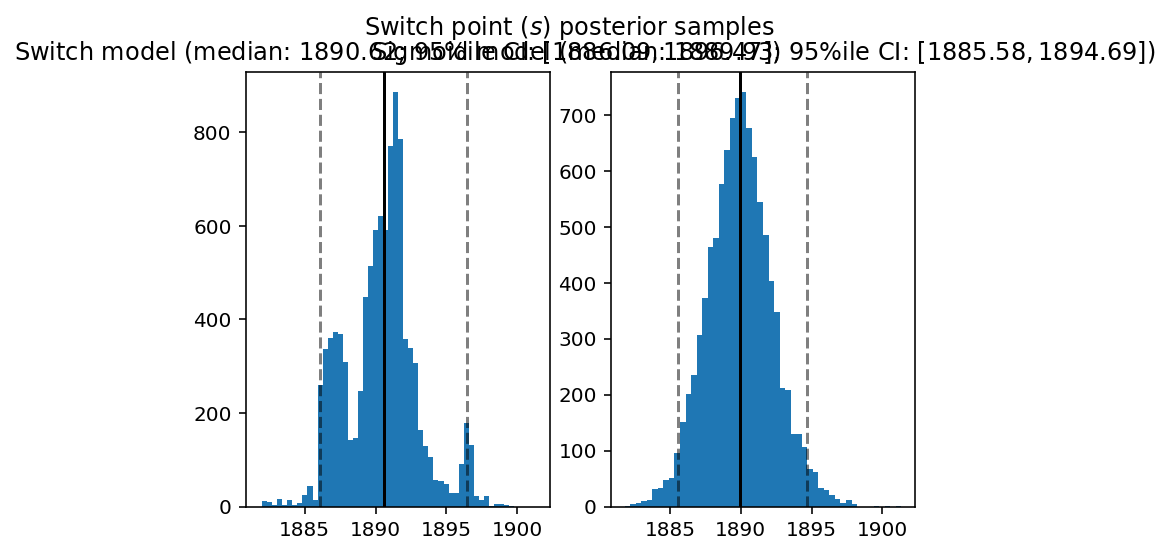

In [12]:
def _desc(v):
  return '(median: {}; 95%ile CI: $[{}, {}]$)'.format(*np.round(np.percentile(v, [50, 2.5, 97.5]), 2))

for t, v in [('Early disaster rate ($e$) posterior samples', early_disaster_rate),
             ('Late disaster rate ($l$) posterior samples', late_disaster_rate),
             ('Switch point ($s$) posterior samples', years[0] + switchpoint)]:
  fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True)
  for (m, i) in (('Switch', 0), ('Sigmoid', 1)):
    a = ax[i]
    a.hist(v[i], bins=50)
    a.axvline(x=np.percentile(v[i], 50), color='k')
    a.axvline(x=np.percentile(v[i], 2.5), color='k', ls='dashed', alpha=.5)
    a.axvline(x=np.percentile(v[i], 97.5), color='k', ls='dashed', alpha=.5)
    a.set_title(m + ' model ' + _desc(v[i]))
  fig.suptitle(t)
  plt.show()

So, according to posterior 
s = 39 (1890 - 1851)
e = 3.04
l = 0.9


In [20]:
print([target_log_prob_fn(m, 39., 3.11, .91).numpy() for m in models]) 

[-177.20285, -176.1388]
